# Our own Embeddings

## Data Load and Exploration

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("data/dataset.csv", encoding="utf-8")

dataset.head()

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


Final Status
Positive     215
Negative     184
Positive       1
Name: count, dtype: int64
Final Status
Positive     0.5375
Negative     0.4600
Positive     0.0025
Name: proportion, dtype: float64


<Axes: xlabel='Final Status'>

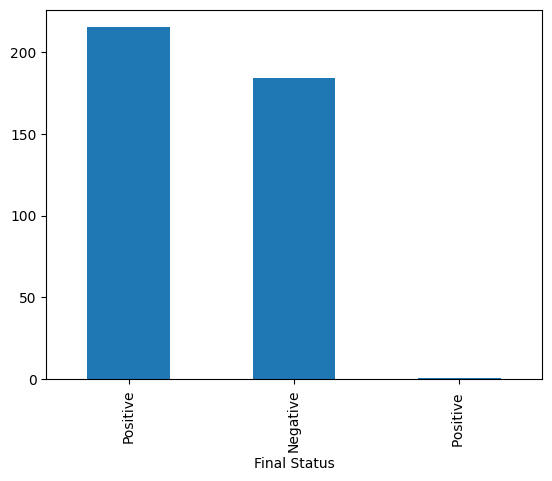

In [2]:
print(dataset["Final Status"].value_counts())

print(dataset["Final Status"].value_counts(normalize=True))

dataset["Final Status"].value_counts().plot(kind="bar")

## Data Cleaning

On line 97 of the original dataset CSV file, a space was found after the class label, originating in a new erroneous class.

In [3]:
dataset.iloc[97]["Final Status"]

'Positive '

In [4]:
dataset.iloc[97]["Final Status"] = 'Positive'
dataset.iloc[97]["Final Status"]

/var/folders/7h/1vqhnhpx2gl_zc8_6pj32nz80000gn/T/ipykernel_23012/987383253.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset.iloc[97]["Final Status"] = 'Positive'


'Positive'

Final Status
Positive    216
Negative    184
Name: count, dtype: int64
Final Status
Positive    0.54
Negative    0.46
Name: proportion, dtype: float64


<Axes: xlabel='Final Status'>

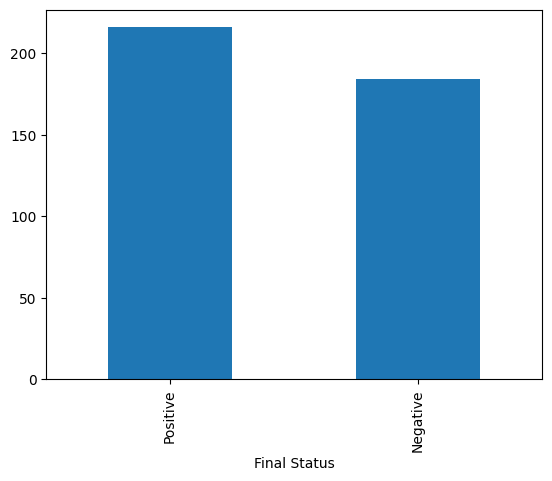

In [5]:
print(dataset["Final Status"].value_counts())

print(dataset["Final Status"].value_counts(normalize=True))

dataset["Final Status"].value_counts().plot(kind="bar")

In [6]:
# Convert to binary
dataset["Final Status"] = dataset["Final Status"].map({"Positive": 1, "Negative": 0})

In [7]:
print("Missing Values:\n", dataset.isnull().sum())

Missing Values:
 Date_published    0
Headline          0
Synopsis          1
Full_text         0
Final Status      0
dtype: int64


Since it's just an empty Synopsis, and we still have the title and full text, then we can leave it in the corpus. (However, we need to converter NaN field to empty string, otherwise the whole article would be ignored on the preprocessing phase.)

In [8]:
# Check  and clean empty Synopsis
dataset[dataset["Synopsis"].isna()].index

Index([56], dtype='int64')

In [9]:
dataset.loc[56, "Synopsis"] = " "

## Preprocessing Text

In [10]:
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [11]:
# list of negative words to be removed from the set stop words, since they may convey sentiment

negative_words = {
    "no",
    "not",
    "none",
    "neither",
    "never",
    "nobody",
    "nothing",
    "nowhere",
    "doesn't",
    "isn't",
    "wasn't",
    "shouldn't",
    "won't",
    "can't",
    "couldn't",
    "don't",
    "haven't",
    "hasn't",
    "hadn't",
    "aren't",
    "weren't",
    "wouldn't",
    "daren't",
    "needn't",
    "didn't",
    "without",
    "against",
    "negative",
    "deny",
    "reject",
    "refuse",
    "decline",
    "unhappy",
    "sad",
    "miserable",
    "hopeless",
    "worthless",
    "useless",
    "futile",
    "disagree",
    "oppose",
    "contrary",
    "contradict",
    "disapprove",
    "dissatisfied",
    "objection",
    "unsatisfactory",
    "unpleasant",
    "regret",
    "resent",
    "lament",
    "mourn",
    "grieve",
    "bemoan",
    "despise",
    "loathe",
    "detract",
    "abhor",
    "dread",
    "fear",
    "worry",
    "anxiety",
    "sorrow",
    "gloom",
    "melancholy",
    "dismay",
    "disheartened",
    "despair",
    "dislike",
    "aversion",
    "antipathy",
    "hate",
    "disdain",
}
sw = set(stopwords.words("english"))
stop_words = sw - negative_words

In [12]:
def preprocess_text(text):
    text = re.sub("[^a-zA-Z]", " ", str(text))  # alpha only
    text = re.sub("\s+", " ", str(text))  # multiple whitespaces
    text = re.sub("[\r\t\n]+", " ", str(text))  # remove carriage retruns, new lines and tabs
    # text = re.sub("[^a-zA-Z0-9]", " ", str(text))  # also numbers
    # text = re.sub("[^a-zA-Z0-9%]", " ", str(text))  # also numbers and %
    # tokens = [token for token in tokens if token not in stop_words]
    # tokens = [ps.stem(token) for token in tokens]
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return text
    # return " ".join(tokens)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7h/1vqhnhpx2gl_zc8_6pj32nz80000gn/T/ipykernel_23012/1977028976.py:3: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub("\s+", " ", str(text))  # multiple whitespaces


For our dataset, we will create a corpus with minimal preprocessing (simply removing non-alpha characters and extra white spaces).

Since we only have 3 textual fields, we will join them insto a single field, to make preprocessing easier.

We will save them in a list called corpus.

In [13]:
corpus = []
dataset["processed_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

for i in range(len(dataset["processed_article"])):
    dataset.loc[i,"processed_article"] = preprocess_text(dataset["processed_article"][i])
    corpus.append(dataset["processed_article"][i])

In [14]:
corpus[:10]

['Banks holding on to subsidy share say payments firms The companies have written to the National Payments Corp of India NPCI complaining that crore of the crore granted in the budget is being retained by banks ReutersPayments companies and banks are at loggerheads over the sharing of government granted subsidies for building payment infrastructure said three people with knowledge of the matter The companies have written to the National Payments Corp of India NPCI complaining that crore of the crore granted in the budget is being retained by banks they said This has deprived companies connecting up the last mile of state promised revenues according to them The government granted the subsidies in exchange for waiving Merchant Discount Rate MDR charges The government has released crore worth of subsidies to banks but they are not sharing it with any payment aggregators said the CEO of a payments company on condition of anonymity Compensation for MDR Waiver We have taken up the matter wit

In [15]:
vocab = set()

for s in corpus:
    vocab.update(s.split())

vocab_size = len(vocab)
print(vocab_size,list(vocab)[:20])

10428 ['downgrading', 'Infoline', 'Orient', 'Steel', 'FII', 'dependency', 'KMPG', 'words', 'extending', 'easy', 'match', 'Strategas', 'stress', 'glad', 'pan', 'relaxation', 'Marcel', 'ripples', 'settle', 'question']


Using gensim, let's create the documents ready for use with embeddings.
We get 400 documents (articles).

Also, an example of preprocessed document. An article becomes a list of tokens, so our documents object is a list of lists.

In [16]:
import gensim

documents = []
for article in corpus:
    documents.append(gensim.utils.simple_preprocess(article))
print(len(documents),documents[0])

400 ['banks', 'holding', 'on', 'to', 'subsidy', 'share', 'say', 'payments', 'firms', 'the', 'companies', 'have', 'written', 'to', 'the', 'national', 'payments', 'corp', 'of', 'india', 'npci', 'complaining', 'that', 'crore', 'of', 'the', 'crore', 'granted', 'in', 'the', 'budget', 'is', 'being', 'retained', 'by', 'banks', 'reuterspayments', 'companies', 'and', 'banks', 'are', 'at', 'loggerheads', 'over', 'the', 'sharing', 'of', 'government', 'granted', 'subsidies', 'for', 'building', 'payment', 'infrastructure', 'said', 'three', 'people', 'with', 'knowledge', 'of', 'the', 'matter', 'the', 'companies', 'have', 'written', 'to', 'the', 'national', 'payments', 'corp', 'of', 'india', 'npci', 'complaining', 'that', 'crore', 'of', 'the', 'crore', 'granted', 'in', 'the', 'budget', 'is', 'being', 'retained', 'by', 'banks', 'they', 'said', 'this', 'has', 'deprived', 'companies', 'connecting', 'up', 'the', 'last', 'mile', 'of', 'state', 'promised', 'revenues', 'according', 'to', 'them', 'the', 'gov

___
# Word2Vec

In [17]:
from gensim.models import KeyedVectors, Word2Vec

from datetime import datetime

start_time = datetime.now()

model = Word2Vec(
    documents, vector_size=150, window=10, min_count=2, workers=10, sg=1
)

print("Training time:", datetime.now() - start_time)

Training time: 0:00:02.294222


Our dataset is very small (400) so it took only a second to train the model...

Lets save the embeddings (word vectors)

In [18]:
model.wv.save("embeddings/ours_wv")

In [19]:
wv = KeyedVectors.load("embeddings/ours_wv")

lets explore the model

In [20]:
wv.most_similar("good")

[('poor', 0.8931384682655334),
 ('very', 0.8903830051422119),
 ('able', 0.8882349729537964),
 ('bull', 0.8803841471672058),
 ('cash', 0.876105546951294),
 ('feel', 0.8756994605064392),
 ('different', 0.8746141195297241),
 ('room', 0.8742269277572632),
 ('changes', 0.8723540306091309),
 ('example', 0.8716426491737366)]

In [21]:
wv.most_similar("bad")

[('nims', 0.9760592579841614),
 ('ebit', 0.9758000373840332),
 ('wage', 0.9750041365623474),
 ('utilisation', 0.9701412916183472),
 ('faced', 0.9699981808662415),
 ('funding', 0.9691202640533447),
 ('topline', 0.969007134437561),
 ('fee', 0.9687876105308533),
 ('recoveries', 0.9687389135360718),
 ('relied', 0.968130350112915)]

In [22]:
wv.most_similar("profit")

[('net', 0.9407430291175842),
 ('latest', 0.9207770824432373),
 ('loss', 0.9148276448249817),
 ('ago', 0.8808404803276062),
 ('corresponding', 0.87965989112854),
 ('ag', 0.8794723749160767),
 ('quarter', 0.876071572303772),
 ('bn', 0.8685170412063599),
 ('standalone', 0.8547544479370117),
 ('clocked', 0.853236973285675)]

In [23]:
wv.most_similar("loss")

[('profit', 0.9148275852203369),
 ('net', 0.9117425680160522),
 ('rationale', 0.8981016874313354),
 ('registering', 0.8914596438407898),
 ('clocked', 0.891089141368866),
 ('aum', 0.8889294266700745),
 ('ag', 0.884674072265625),
 ('nii', 0.8813295960426331),
 ('standalone', 0.8796494007110596),
 ('revenues', 0.8789613246917725)]

In [24]:
def text_to_mean_vector(embeddings, text):
    tokens = text.split()
    vectors = []

    for token in tokens:
        try:
            vector = embeddings.get_vector(token)
            vectors.append(vector)
        except KeyError:
            pass  # ignore out-of-vocabulary tokens

    mean_vector = np.mean(vectors, axis=0)

    return mean_vector

In [25]:
mean_embeddings_corpus = []
for c in corpus:
    mean_embeddings_corpus.append(text_to_mean_vector(model.wv, c))

X = np.array(mean_embeddings_corpus)
y = dataset["Final Status"]


print(X.shape, y.shape)

(400, 150) (400,)


In [26]:
# def text_to_max(embeddings, text):
#     tokens = text.split()
#     vectors = []

#     for token in tokens:
#         try:
#             vector = embeddings.get_vector(token)
#             vectors.append(vector)
#         except KeyError:
#             pass  # ignore out-of-vocabulary tokens

#     stacked_vectors = np.stack(vectors)
#     max_vector = np.max(stacked_vectors, axis=0)

#     return max_vector

In [27]:
# max_embeddings_corpus = []
# for c in corpus:
#     max_embeddings_corpus.append(text_to_max(model, c))

# X = np.array(max_embeddings_corpus)

# print(X.shape)

In [28]:
from sklearn.model_selection import (
    train_test_split,
    ParameterGrid,
    GridSearchCV,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(320, 150) (320,)
(80, 150) (80,)

Label distribution in the training set:
Final Status
1    176
0    144
Name: count, dtype: int64

Label distribution in the test set:
Final Status
0    40
1    40
Name: count, dtype: int64


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [30]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "Multi-Layer Perceptron": MLPClassifier(),
    "XGBoost": XGBClassifier(),
}

In [31]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [32]:
best_params_so_far = {
    "Logistic Regression": {
        "C": 10.0,
        "max_iter": 1000,
        "penalty": "l1",
        "solver": "liblinear",
    },
    "Decision Tree": {
        "criterion": "entropy",
        "max_depth": 20,
        "min_samples_leaf": 4,
        "min_samples_split": 2,
    },
    "Random Forest": {
        "max_depth": None,
        "min_samples_leaf": 2,
        "min_samples_split": 5,
        "n_estimators": 300,
    },
    "SVC": {"C": 10.0, "gamma": "scale", "kernel": "sigmoid"},
    "Multi-Layer Perceptron": {
        "activation": "identity",
        "alpha": 0.01,
        "early_stopping": True,
        "hidden_layer_sizes": (25, 25, 25),
        "max_iter": 500,
        "n_iter_no_change": 10,
    },
    "XGBoost": {
        "learning_rate": 0.01,
        "max_depth": 6,
        "n_estimators": 200,
        "subsample": 0.8,
    },
}

In [33]:
best_params = best_params_so_far

In [34]:
classifiers_tuned = {
    "Logistic Regression": LogisticRegression(**best_params["Logistic Regression"]),
    "Decision Tree": DecisionTreeClassifier(**best_params["Decision Tree"]),
    "Random Forest": RandomForestClassifier(**best_params["Random Forest"]),
    "SVC": SVC(**best_params["SVC"]),
    "Multi-Layer Perceptron": MLPClassifier(**best_params["Multi-Layer Perceptron"]),
    "XGBoost": XGBClassifier(**best_params["XGBoost"]),
}

In [35]:
evaluations = {
    classifier_name: evaluate_classifier(classifier, X_train, y_train, X_test, y_test)
    for classifier_name, classifier in classifiers_tuned.items()
}

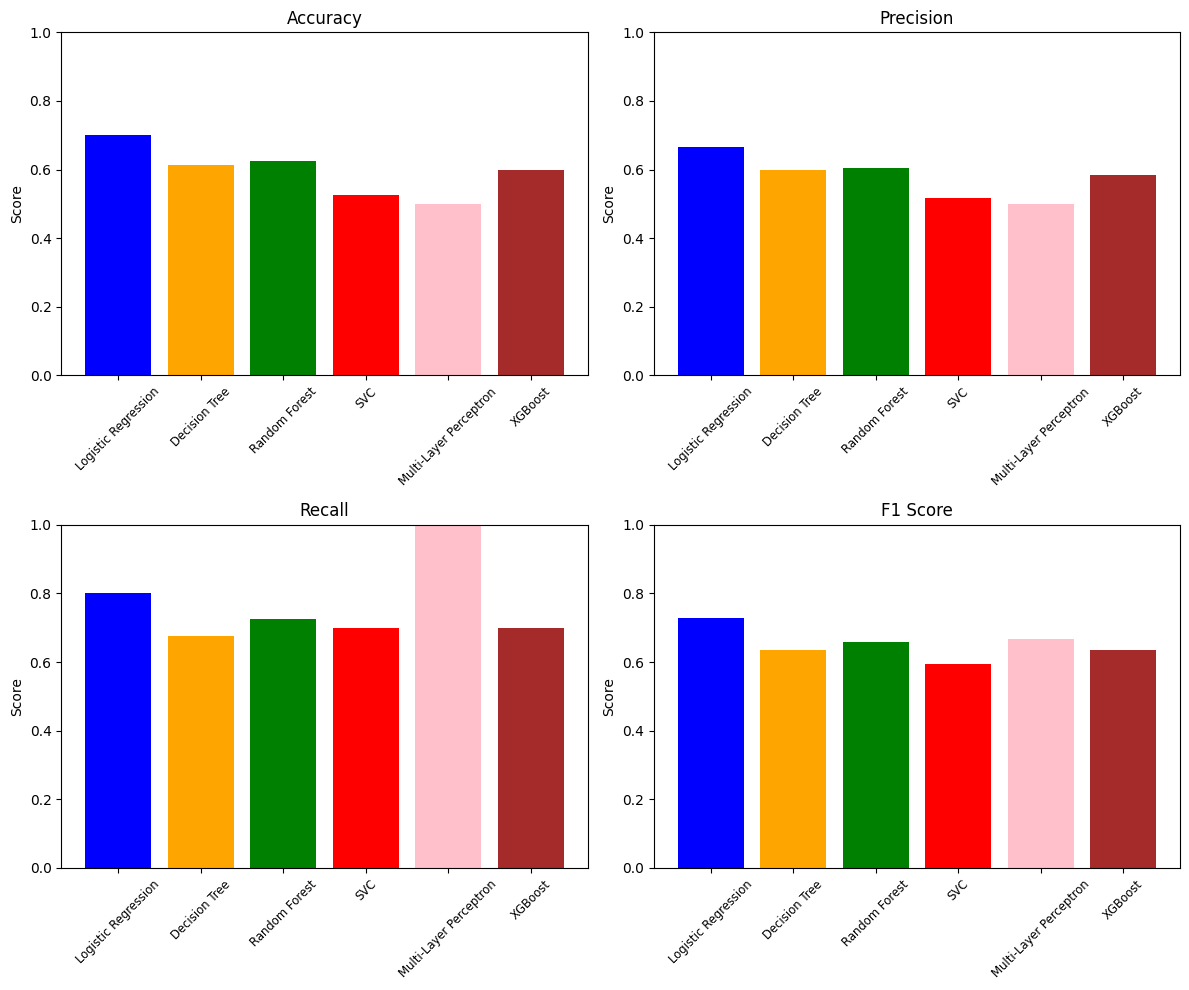

Classifier: Logistic Regression
Accuracy: 0.70
Precision: 0.67
Recall: 0.80
F1 Score: 0.73
------------------------------
Classifier: Decision Tree
Accuracy: 0.61
Precision: 0.60
Recall: 0.68
F1 Score: 0.64
------------------------------
Classifier: Random Forest
Accuracy: 0.62
Precision: 0.60
Recall: 0.72
F1 Score: 0.66
------------------------------
Classifier: SVC
Accuracy: 0.53
Precision: 0.52
Recall: 0.70
F1 Score: 0.60
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.50
Precision: 0.50
Recall: 1.00
F1 Score: 0.67
------------------------------
Classifier: XGBoost
Accuracy: 0.60
Precision: 0.58
Recall: 0.70
F1 Score: 0.64
------------------------------


In [36]:
import matplotlib.pyplot as plt

metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

Altough not bad, the vector space doesn't capture well the relations between words.

___

## Visualization

In [37]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def reduce_dimensions(model, num_dimensions=3, words=[], perplexity=None):
    vectors = np.array([model.wv.get_vector(word) for word in words])

    if perplexity is None:
        perplexity = min(30, len(vectors) - 1)

    tsne = TSNE(n_components=num_dimensions, perplexity=perplexity, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)

    return reduced_vectors, words


def visualize_embeddings(
    x_vals,
    y_vals,
    z_vals,
    labels,
    point_size=10,
    point_color="blue",
    label_color="black",
    label_size=10,
):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    for i, label in enumerate(labels):
        x = x_vals[i]
        y = y_vals[i]
        z = z_vals[i]
        ax.scatter(x, y, z, s=point_size, c=point_color, marker="o")
        ax.text(x, y, z, label, color=label_color, size=label_size)
    plt.show()

___

## Visualization

In [38]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def reduce_dimensions(model, num_dimensions=3, words=[], perplexity=None):
    vectors = np.array([model.wv.get_vector(word) for word in words])

    if perplexity is None:
        perplexity = min(30, len(vectors) - 1)

    tsne = TSNE(n_components=num_dimensions, perplexity=perplexity, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)

    return reduced_vectors, words


def visualize_embeddings(
    x_vals,
    y_vals,
    z_vals,
    labels,
    point_size=10,
    point_color="blue",
    label_color="black",
    label_size=10,
):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    for i, label in enumerate(labels):
        x = x_vals[i]
        y = y_vals[i]
        z = z_vals[i]
        ax.scatter(x, y, z, s=point_size, c=point_color, marker="o")
        ax.text(x, y, z, label, color=label_color, size=label_size)
    plt.show()

In [39]:
keys = [
    "profit",
    "investment",
    "finance",
    "shares",
    "risk",
    "assets",
    "liability",
    "credit",
    "capital",
    "exposure",
    "tax",
]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

python(23061) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


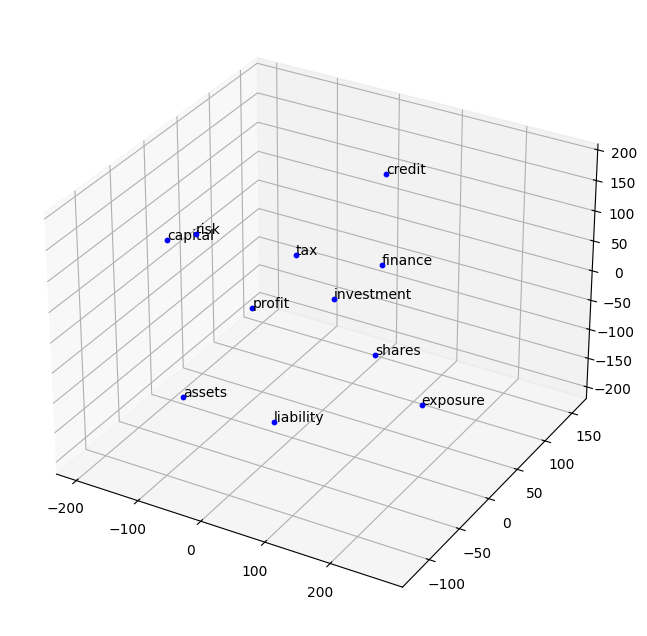

In [40]:
reduced_embeddings, words_to_visualize = reduce_dimensions(
    model, num_dimensions=3, words=keys
)
visualize_embeddings(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    reduced_embeddings[:, 2],
    words_to_visualize
)

In [41]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(
    perplexity=15, n_components=2, init="pca", n_iter=2500, random_state=32
)
embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
).reshape(n, m, 2)

/var/folders/7h/1vqhnhpx2gl_zc8_6pj32nz80000gn/T/ipykernel_23012/3042592960.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


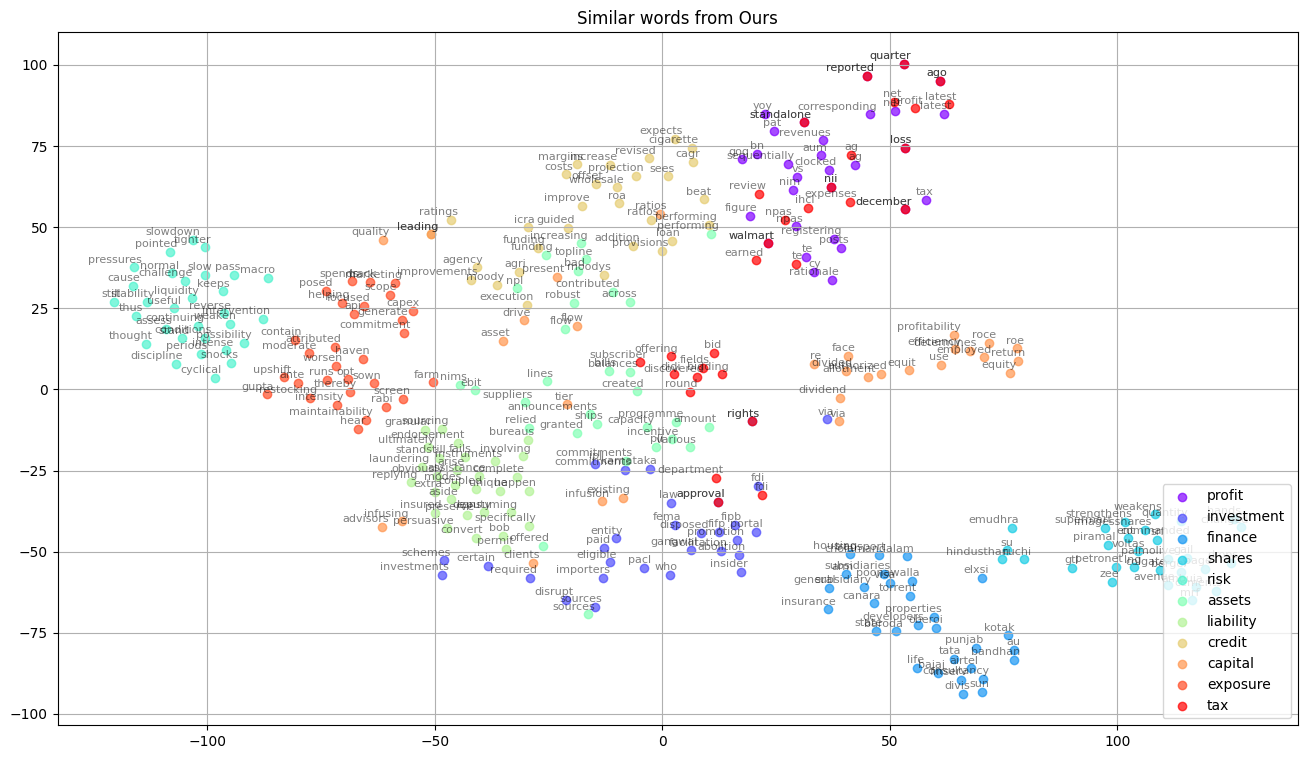

In [42]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Ours', keys, embeddings_en_2d, word_clusters, 0.7,
                        'figs/ours.png')